# TYC 70 WL segmentation pipeline

In [2]:
# Use cellpose env
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import cv2
import numpy as np
from skimage.measure import regionprops, label
from skimage.segmentation import relabel_sequential
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi
from scipy.optimize import linear_sum_assignment
from cellpose import models
import matplotlib.pyplot as plt
import random

# model_type='cyto' or 'nuclei' or 'cyto2' OR 'cyto3'
model = models.Cellpose(model_type='cyto')


## Code for frame 0 ROI 17

In [3]:
# --- CONFIGURATION ---
WL_PATH = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif"
MEMBRANE_PATH = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_ImgGS\72hr_recording_50B_2000ms_frame00000_ROI17.tif"
MIN_CLUSTER_SIZE = 3000
MIN_FINAL_CELL_SIZE = 500
CELLPOSE_DIAMETER = 40
IOU_THRESHOLD = 0.4

In [4]:
# --- CONFIGURATION ---
WL_PATH = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17.tif"
MEMBRANE_PATH = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_ImgGS\72hr_recording_50B_2000ms_frame00000_ROI17.tif"
MIN_CLUSTER_SIZE = 3000
MIN_FINAL_CELL_SIZE = 500
CELLPOSE_DIAMETER = 40
IOU_THRESHOLD = 0.4

# --- STEP 1: Load and preprocess WL image ---
wl_img_raw = cv2.imread(WL_PATH, -1)
wl_blur = cv2.GaussianBlur(wl_img_raw, (5, 5), 0)
wl_edge = cv2.Laplacian(wl_blur, cv2.CV_64F)
wl_edge_abs = np.abs(wl_edge)
wl_edge_norm = cv2.normalize(wl_edge_abs, None, 0, 255, cv2.NORM_MINMAX)
wl_edge_bin = cv2.threshold(wl_edge_norm.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
wl_closed = cv2.dilate(wl_edge_bin, kernel_dilate)
wl_opened = cv2.erode(wl_closed, kernel_erode)
wl_filled = ndi.binary_fill_holes(wl_opened > 0)
wl_clean = morphology.remove_small_objects(wl_filled.astype(bool), min_size=MIN_CLUSTER_SIZE)
wl_smooth = cv2.GaussianBlur(wl_clean.astype(np.uint8), (15, 15), 0)
wl_smooth_clean = morphology.remove_small_objects(wl_smooth.astype(bool), min_size=MIN_CLUSTER_SIZE)
wl_label = label(wl_smooth_clean)

# --- STEP 2: Cellpose on WL image (mocked as masks_small) ---
wl_input_for_cellpose = cv2.GaussianBlur(wl_img_raw, (15, 15), cv2.BORDER_DEFAULT)
wl_input_for_cellpose = (wl_input_for_cellpose - np.min(wl_input_for_cellpose)) / (np.max(wl_input_for_cellpose) - np.min(wl_input_for_cellpose)) * 75
# Assume model is already defined as 'model'
masks_small, _, _, _ = model.eval(wl_input_for_cellpose, diameter=CELLPOSE_DIAMETER, channels=[0, 0])

# --- STEP 3: Merge Cellpose with WL clusters using IoU ---
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

final_combined_mask = np.zeros_like(masks_small)
label_cp = label(masks_small)
label_cl = label(wl_label)
props_cp = regionprops(label_cp)
props_cl = regionprops(label_cl)
used_clusters = set()
label_id = 1

for cp in props_cp:
    minr, minc, maxr, maxc = cp.bbox
    cp_mask = np.zeros_like(masks_small)
    cp_mask[tuple(cp.coords.T)] = 1
    cluster_crop = label_cl[minr:maxr, minc:maxc]
    cp_crop = cp_mask[minr:maxr, minc:maxc]
    overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
    overlapping_ids = overlapping_ids[overlapping_ids > 0]

    if len(overlapping_ids) == 0:
        final_combined_mask[tuple(cp.coords.T)] = label_id
        label_id += 1
    else:
        ious = [compute_iou(cp_mask, np.isin(label_cl, oid)) for oid in overlapping_ids]
        if max(ious) < IOU_THRESHOLD:
            final_combined_mask[tuple(cp.coords.T)] = label_id
            label_id += 1
        else:
            best_match = overlapping_ids[np.argmax(ious)]
            final_combined_mask[tuple(cp.coords.T)] = best_match
            used_clusters.add(best_match)

# Add untouched clusters
for cl in props_cl:
    if cl.label not in used_clusters:
        final_combined_mask[tuple(cl.coords.T)] = label_id
        label_id += 1

# --- STEP 4: Add membrane segmentation ---
membrane_mask = label(cv2.imread(MEMBRANE_PATH, -1))
final_combined_mask = final_combined_mask.astype(np.int32)
membrane_mask = membrane_mask.astype(np.int32)

# Build combined mask
combined = np.zeros_like(final_combined_mask)
overlap = (final_combined_mask > 0) & (membrane_mask > 0)
wl_only = (final_combined_mask > 0) & (membrane_mask == 0)
membrane_only = (membrane_mask > 0) & (final_combined_mask == 0)

membrane_mask = label(membrane_mask)
combined[wl_only] = final_combined_mask[wl_only]
combined[membrane_only] = membrane_mask[membrane_only] + final_combined_mask.max()
combined[overlap] = final_combined_mask[overlap]  # Keep WL for overlap

# Filter and relabel
cleaned_combined = remove_small_objects(combined, min_size=MIN_FINAL_CELL_SIZE)
final_mask_labeled, _, _ = relabel_sequential(label(cleaned_combined))


In [5]:
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\test\72hr_recording_WL_1ms_WhiteLight_frame00000_ROI17_final.tif"
final_mask_labeled = final_mask_labeled.astype(np.uint16)
cv2.imwrite(output_path, final_mask_labeled)

True

### Accuracy check

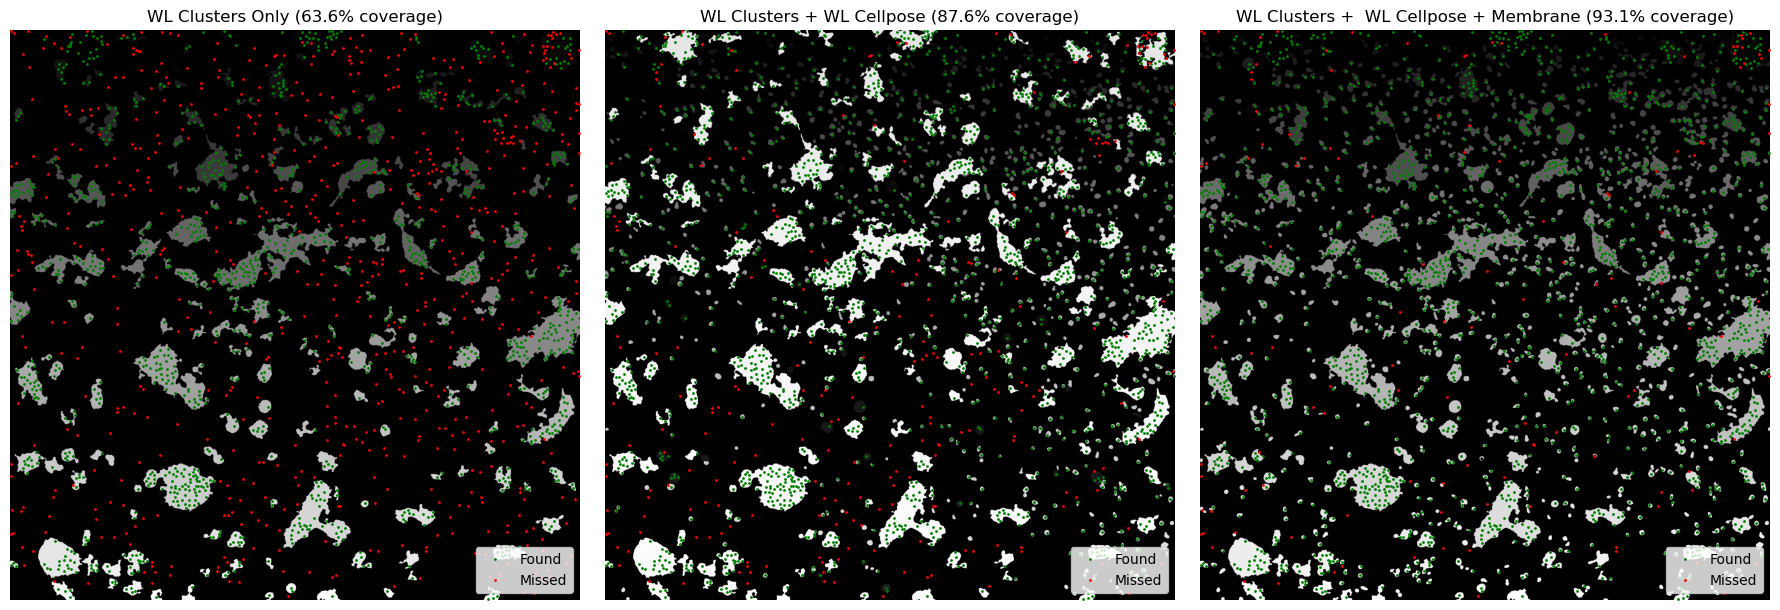


--- Detection Accuracy Summary ---
WL Clusters Only: 1192/1873 nuclei → 63.64%
WL Clusters + WL Cellpose: 1641/1873 nuclei → 87.61%
WL Clusters +  WL Cellpose + Membrane: 1743/1873 nuclei → 93.06%


In [12]:
# Load and label the nucleus mask
nucleus_mask_file = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\637nm_ImgGS\72hr_recording_50R_2500ms_frame00000_ROI17.tif"
nucleus_mask_img = cv2.imread(nucleus_mask_file, -1)
labeled_mask_nucleus = label(nucleus_mask_img)
props_nucleus = regionprops(labeled_mask_nucleus)

# Filter out micronuclei (too small)
MICRONUCLEI_SIZE_THRESHOLD = 200
props_nucleus = regionprops(labeled_mask_nucleus)

# Only keep objects larger than the threshold
filtered_props = [prop for prop in props_nucleus if prop.area >= MICRONUCLEI_SIZE_THRESHOLD]

# Extract centroids of the filtered nuclei
centroids = [prop.centroid for prop in filtered_props]

# Define function to compute detection stats
def compute_nucleus_coverage(nuclei_centroids, segmentation_mask):
    found = []
    missed = []
    for y, x in nuclei_centroids:
        y_int, x_int = int(round(y)), int(round(x))
        if 0 <= y_int < segmentation_mask.shape[0] and 0 <= x_int < segmentation_mask.shape[1]:
            if segmentation_mask[y_int, x_int]:
                found.append((x, y))
            else:
                missed.append((x, y))
    return np.array(found), np.array(missed)

# Evaluate each stage
stage_names = ['WL Clusters Only', 'WL Clusters + WL Cellpose', 'WL Clusters +  WL Cellpose + Membrane']
masks = [wl_label, final_combined_mask, final_mask_labeled]
results = []

for stage_name, mask in zip(stage_names, masks):
    found, missed = compute_nucleus_coverage(centroids, mask)
    coverage = 100 * len(found) / len(centroids) if len(centroids) > 0 else 0
    results.append({
        'name': stage_name,
        'found': found,
        'missed': missed,
        'coverage': coverage
    })

# Plot side-by-side comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, result, mask in zip(axs, results, masks):
    ax.imshow(mask, cmap='gray')
    if result['found'].size:
        ax.plot(result['found'][:, 0], result['found'][:, 1], 'go', markersize=1, label='Found')
    if result['missed'].size:
        ax.plot(result['missed'][:, 0], result['missed'][:, 1], 'ro', markersize=1, label='Missed')
    ax.set_title(f"{result['name']} ({result['coverage']:.1f}% coverage)")
    ax.axis('off')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Print summary
print("\n--- Detection Accuracy Summary ---")
for result in results:
    print(f"{result['name']}: {len(result['found'])}/{len(centroids)} nuclei → {result['coverage']:.2f}%")

## For loop frame 0 all ROI's

In [13]:
# --- Parameters ---
MIN_CLUSTER_SIZE = 3000
MIN_FINAL_CELL_SIZE = 500
MICRONUCLEI_SIZE_THRESHOLD = 200
CELLPOSE_DIAMETER = 40
IOU_THRESHOLD = 0.4

# --- Paths ---
base_wl = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight"
base_membrane = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_ImgGS"
out_clusters = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_only"
out_cellpose = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose"
out_final = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose_460nm"

os.makedirs(out_clusters, exist_ok=True)
os.makedirs(out_cellpose, exist_ok=True)
os.makedirs(out_final, exist_ok=True)

In [ ]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

# --- Loop through ROIs ---
for roi in range(20):
    roi_str = f"ROI{roi}"
    fname = f"72hr_recording_WL_1ms_WhiteLight_frame00000_{roi_str}.tif"

    # File paths
    wl_path = os.path.join(base_wl, fname)
    membrane_path = os.path.join(base_membrane, f"72hr_recording_50B_2000ms_frame00000_{roi_str}.tif")

    if not os.path.exists(wl_path) or not os.path.exists(membrane_path):
        print(f"Skipping {roi_str}: files not found.")
        continue

    # --- WL segmentation (clusters only) ---
    wl_img_raw = cv2.imread(wl_path, -1)
    wl_blur = cv2.GaussianBlur(wl_img_raw, (5, 5), 0)
    wl_edge = cv2.Laplacian(wl_blur, cv2.CV_64F)
    wl_edge_abs = np.abs(wl_edge)
    wl_edge_norm = cv2.normalize(wl_edge_abs, None, 0, 255, cv2.NORM_MINMAX)
    wl_edge_bin = cv2.threshold(wl_edge_norm.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
    wl_closed = cv2.dilate(wl_edge_bin, kernel_dilate)
    wl_opened = cv2.erode(wl_closed, kernel_erode)
    wl_filled = ndi.binary_fill_holes(wl_opened > 0)
    wl_clean = remove_small_objects(wl_filled.astype(bool), min_size=MIN_CLUSTER_SIZE)
    wl_smooth = cv2.GaussianBlur(wl_clean.astype(np.uint8), (15, 15), 0)
    wl_smooth_clean = remove_small_objects(wl_smooth.astype(bool), min_size=MIN_CLUSTER_SIZE)
    wl_label = label(wl_smooth_clean)

    # --- Save WL clusters only ---
    out1 = os.path.join(out_clusters, fname)
    cv2.imwrite(out1, wl_label.astype(np.uint16))

    # --- Cellpose on WL ---
    wl_input_for_cellpose = cv2.GaussianBlur(wl_img_raw, (15, 15), cv2.BORDER_DEFAULT)
    wl_input_for_cellpose = (wl_input_for_cellpose - np.min(wl_input_for_cellpose)) / (np.max(wl_input_for_cellpose) - np.min(wl_input_for_cellpose)) * 75
    masks_small, _, _, _ = model.eval(wl_input_for_cellpose, diameter=CELLPOSE_DIAMETER, channels=[0, 0])

    # --- Merge Cellpose with clusters ---
    final_combined_mask = np.zeros_like(masks_small)
    label_cp = label(masks_small)
    label_cl = label(wl_label)
    props_cp = regionprops(label_cp)
    props_cl = regionprops(label_cl)
    used_clusters = set()
    label_id = 1

    for cp in props_cp:
        minr, minc, maxr, maxc = cp.bbox
        cp_mask = np.zeros_like(masks_small)
        cp_mask[tuple(cp.coords.T)] = 1
        cluster_crop = label_cl[minr:maxr, minc:maxc]
        cp_crop = cp_mask[minr:maxr, minc:maxc]
        overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
        overlapping_ids = overlapping_ids[overlapping_ids > 0]

        if len(overlapping_ids) == 0:
            final_combined_mask[tuple(cp.coords.T)] = label_id
            label_id += 1
        else:
            ious = [compute_iou(cp_mask, np.isin(label_cl, oid)) for oid in overlapping_ids]
            if max(ious) < IOU_THRESHOLD:
                final_combined_mask[tuple(cp.coords.T)] = label_id
                label_id += 1
            else:
                best_match = overlapping_ids[np.argmax(ious)]
                final_combined_mask[tuple(cp.coords.T)] = best_match
                used_clusters.add(best_match)

    for cl in props_cl:
        if cl.label not in used_clusters:
            final_combined_mask[tuple(cl.coords.T)] = label_id
            label_id += 1

    # --- Save merged mask (WL + Cellpose) ---
    out2 = os.path.join(out_cellpose, fname)
    cv2.imwrite(out2, final_combined_mask.astype(np.uint16))

    # --- Add Membrane ---
    membrane_mask = label(cv2.imread(membrane_path, -1))
    combined = np.zeros_like(final_combined_mask)
    overlap = (final_combined_mask > 0) & (membrane_mask > 0)
    wl_only = (final_combined_mask > 0) & (membrane_mask == 0)
    membrane_only = (membrane_mask > 0) & (final_combined_mask == 0)

    membrane_mask = label(membrane_mask)
    combined[wl_only] = final_combined_mask[wl_only]
    combined[membrane_only] = membrane_mask[membrane_only] + final_combined_mask.max()
    combined[overlap] = final_combined_mask[overlap]

    # --- Final filtering ---
    cleaned_combined = remove_small_objects(combined, min_size=MIN_FINAL_CELL_SIZE)
    final_mask_labeled, _, _ = relabel_sequential(label(cleaned_combined))

    # --- Save final mask (WL + CP + membrane) ---
    out3 = os.path.join(out_final, fname)
    cv2.imwrite(out3, final_mask_labeled.astype(np.uint16))

    print(f"Saved ROI {roi} to disk.")

print("All ROIs processed.")

Saved ROI 0 to disk.
Saved ROI 1 to disk.
Saved ROI 2 to disk.
Saved ROI 3 to disk.
Saved ROI 4 to disk.
Saved ROI 5 to disk.
Saved ROI 6 to disk.
Saved ROI 7 to disk.
Saved ROI 8 to disk.
Saved ROI 9 to disk.
Saved ROI 10 to disk.
Saved ROI 11 to disk.
Saved ROI 12 to disk.
Saved ROI 13 to disk.
Saved ROI 14 to disk.
Saved ROI 15 to disk.
Saved ROI 16 to disk.
Saved ROI 17 to disk.
Saved ROI 18 to disk.
Saved ROI 19 to disk.
All ROIs processed.


### Accuracy check

In [16]:
# --- Constants ---
MICRONUCLEI_SIZE_THRESHOLD = 200
NUM_ROIS = 20

# --- Paths ---
wl_only_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_only"
wl_cp_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose"
final_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose_460nm"
nucleus_base = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\637nm_ImgGS"

In [19]:
# --- Accuracy computation ---
def compute_nucleus_coverage(nuclei_centroids, segmentation_mask):
    found = []
    missed = []
    for y, x in nuclei_centroids:
        y_int, x_int = int(round(y)), int(round(x))
        if 0 <= y_int < segmentation_mask.shape[0] and 0 <= x_int < segmentation_mask.shape[1]:
            if segmentation_mask[y_int, x_int]:
                found.append((x, y))
            else:
                missed.append((x, y))
    return np.array(found), np.array(missed)

# --- Track totals ---
total_counts = {
    'WL Clusters Only': {'found': 0, 'total': 0, 'micronuclei': 0},
    'WL Clusters + WL Cellpose': {'found': 0, 'total': 0, 'micronuclei': 0},
    'WL Clusters +  WL Cellpose + Membrane': {'found': 0, 'total': 0, 'micronuclei': 0}
}

# --- Main loop ---
for roi in range(NUM_ROIS):
    roi_str = f"ROI{roi}"
    fname = f"72hr_recording_WL_1ms_WhiteLight_frame00000_{roi_str}.tif"
    nucleus_file = f"72hr_recording_50R_2500ms_frame00000_{roi_str}.tif"

    # Load masks
    try:
        wl_label = cv2.imread(os.path.join(wl_only_path, fname), -1)
        final_combined_mask = cv2.imread(os.path.join(wl_cp_path, fname), -1)
        final_mask_labeled = cv2.imread(os.path.join(final_path, fname), -1)
        nucleus_mask_img = cv2.imread(os.path.join(nucleus_base, nucleus_file), -1)
    except Exception as e:
        print(f"Skipping {roi_str}: Error loading files - {e}")
        continue

    if any(x is None for x in [wl_label, final_combined_mask, final_mask_labeled, nucleus_mask_img]):
        print(f"Skipping {roi_str}: One or more files not found.")
        continue

    # Label and filter nucleus mask
    labeled_mask_nucleus = label(nucleus_mask_img)
    props_nucleus = regionprops(labeled_mask_nucleus)
    
    # Filter micronuclei (too small)
    micronuclei = [prop for prop in props_nucleus if prop.area < MICRONUCLEI_SIZE_THRESHOLD]
    filtered_props = [prop for prop in props_nucleus if prop.area >= MICRONUCLEI_SIZE_THRESHOLD]
    
    # Count micronuclei for this ROI
    micronuclei_count = len(micronuclei)

    # Extract centroids of the filtered nuclei
    centroids = [prop.centroid for prop in filtered_props]

    # Skip empty ground truth
    if len(centroids) == 0:
        print(f"{roi_str}: No valid nuclei found.")
        continue

    # Evaluate each stage
    stage_names = ['WL Clusters Only', 'WL Clusters + WL Cellpose', 'WL Clusters +  WL Cellpose + Membrane']
    masks = [wl_label, final_combined_mask, final_mask_labeled]
    
    print(f"\n=== ROI {roi_str} Accuracy ===")
    for stage_name, mask in zip(stage_names, masks):
        found, missed = compute_nucleus_coverage(centroids, mask)
        coverage = 100 * len(found) / len(centroids)
        print(f"{stage_name}: {len(found)}/{len(centroids)} nuclei → {coverage:.2f}%")

        # Update global counters
        total_counts[stage_name]['found'] += len(found)
        total_counts[stage_name]['total'] += len(centroids)
        total_counts[stage_name]['micronuclei'] += micronuclei_count  # Update micronuclei count for this stage

    print(f"  Micronuclei filtered: {micronuclei_count}")

# --- Overall summary ---
print("\n=== OVERALL AVERAGE ACCURACY ===")
for stage_name in stage_names:
    found = total_counts[stage_name]['found']
    total = total_counts[stage_name]['total']
    micronuclei = total_counts[stage_name]['micronuclei']
    coverage = 100 * found / total if total > 0 else 0
    print(f"{stage_name}: {found}/{total} nuclei → {coverage:.2f}%")
    print(f"  Micronuclei filtered: {micronuclei}")


=== ROI ROI0 Accuracy ===
WL Clusters Only: 968/1176 nuclei → 82.31%
WL Clusters + WL Cellpose: 1091/1176 nuclei → 92.77%
WL Clusters +  WL Cellpose + Membrane: 1124/1176 nuclei → 95.58%
  Micronuclei filtered: 68

=== ROI ROI1 Accuracy ===
WL Clusters Only: 985/1314 nuclei → 74.96%
WL Clusters + WL Cellpose: 1172/1314 nuclei → 89.19%
WL Clusters +  WL Cellpose + Membrane: 1199/1314 nuclei → 91.25%
  Micronuclei filtered: 54

=== ROI ROI2 Accuracy ===
WL Clusters Only: 932/1255 nuclei → 74.26%
WL Clusters + WL Cellpose: 1135/1255 nuclei → 90.44%
WL Clusters +  WL Cellpose + Membrane: 1181/1255 nuclei → 94.10%
  Micronuclei filtered: 74

=== ROI ROI3 Accuracy ===
WL Clusters Only: 881/1196 nuclei → 73.66%
WL Clusters + WL Cellpose: 1073/1196 nuclei → 89.72%
WL Clusters +  WL Cellpose + Membrane: 1133/1196 nuclei → 94.73%
  Micronuclei filtered: 80

=== ROI ROI4 Accuracy ===
WL Clusters Only: 953/1198 nuclei → 79.55%
WL Clusters + WL Cellpose: 1071/1198 nuclei → 89.40%
WL Clusters +  WL

## Code for specific ROI or frames

### Segmentation pipeline

In [3]:
# --- Parameters ---
MIN_CLUSTER_SIZE = 3000
MIN_FINAL_CELL_SIZE = 500
MICRONUCLEI_SIZE_THRESHOLD = 200
CELLPOSE_DIAMETER = 40
IOU_THRESHOLD = 0.4

# --- Paths ---
base_wl = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight"
base_membrane = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\460nm_ImgGS"
out_clusters = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_only"
out_cellpose = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose"
out_final = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose_460nm"

os.makedirs(out_clusters, exist_ok=True)
os.makedirs(out_cellpose, exist_ok=True)
os.makedirs(out_final, exist_ok=True)

# --- Loop through specified frames and ROIs ---
frames_to_process = range(0, 61)
rois_to_process = range(0, 1)


In [4]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

for frame in frames_to_process:
    for roi in rois_to_process:
        
        roi = 17

        roi_str = f"ROI{roi}"
        fname = f"72hr_recording_WL_1ms_WhiteLight_frame{frame:05d}_{roi_str}.tif"
        membrane_fname = f"72hr_recording_50B_2000ms_frame{frame:05d}_{roi_str}.tif"

        # File paths
        wl_path = os.path.join(base_wl, fname)
        membrane_path = os.path.join(base_membrane, membrane_fname)

        if not os.path.exists(wl_path) or not os.path.exists(membrane_path):
            print(f"Skipping {roi_str} (Frame {frame}): Files not found.")
            continue

        # --- WL segmentation (clusters only) ---
        wl_img_raw = cv2.imread(wl_path, -1)
        wl_blur = cv2.GaussianBlur(wl_img_raw, (5, 5), 0)
        wl_edge = cv2.Laplacian(wl_blur, cv2.CV_64F)
        wl_edge_abs = np.abs(wl_edge)
        wl_edge_norm = cv2.normalize(wl_edge_abs, None, 0, 255, cv2.NORM_MINMAX)
        wl_edge_bin = cv2.threshold(wl_edge_norm.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
        wl_closed = cv2.dilate(wl_edge_bin, kernel_dilate)
        wl_opened = cv2.erode(wl_closed, kernel_erode)
        wl_filled = ndi.binary_fill_holes(wl_opened > 0)
        wl_clean = remove_small_objects(wl_filled.astype(bool), min_size=MIN_CLUSTER_SIZE)
        wl_smooth = cv2.GaussianBlur(wl_clean.astype(np.uint8), (15, 15), 0)
        wl_smooth_clean = remove_small_objects(wl_smooth.astype(bool), min_size=MIN_CLUSTER_SIZE)
        wl_label = label(wl_smooth_clean)

        # --- Save WL clusters only ---
        out1 = os.path.join(out_clusters, fname)
        cv2.imwrite(out1, wl_label.astype(np.uint16))

        # --- Cellpose on WL ---
        wl_input_for_cellpose = cv2.GaussianBlur(wl_img_raw, (15, 15), cv2.BORDER_DEFAULT)
        wl_input_for_cellpose = (wl_input_for_cellpose - np.min(wl_input_for_cellpose)) / (np.max(wl_input_for_cellpose) - np.min(wl_input_for_cellpose)) * 75
        masks_small, _, _, _ = model.eval(wl_input_for_cellpose, diameter=CELLPOSE_DIAMETER, channels=[0, 0])

        # --- Merge Cellpose with clusters ---
        final_combined_mask = np.zeros_like(masks_small)
        label_cp = label(masks_small)
        label_cl = label(wl_label)
        props_cp = regionprops(label_cp)
        props_cl = regionprops(label_cl)
        used_clusters = set()
        label_id = 1

        for cp in props_cp:
            minr, minc, maxr, maxc = cp.bbox
            cp_mask = np.zeros_like(masks_small)
            cp_mask[tuple(cp.coords.T)] = 1
            cluster_crop = label_cl[minr:maxr, minc:maxc]
            cp_crop = cp_mask[minr:maxr, minc:maxc]
            overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
            overlapping_ids = overlapping_ids[overlapping_ids > 0]

            if len(overlapping_ids) == 0:
                final_combined_mask[tuple(cp.coords.T)] = label_id
                label_id += 1
            else:
                ious = [compute_iou(cp_mask, np.isin(label_cl, oid)) for oid in overlapping_ids]
                if max(ious) < IOU_THRESHOLD:
                    final_combined_mask[tuple(cp.coords.T)] = label_id
                    label_id += 1
                else:
                    best_match = overlapping_ids[np.argmax(ious)]
                    final_combined_mask[tuple(cp.coords.T)] = best_match
                    used_clusters.add(best_match)

        for cl in props_cl:
            if cl.label not in used_clusters:
                final_combined_mask[tuple(cl.coords.T)] = label_id
                label_id += 1

        # --- Save merged mask (WL + Cellpose) ---
        out2 = os.path.join(out_cellpose, fname)
        cv2.imwrite(out2, final_combined_mask.astype(np.uint16))

        # --- Add Membrane ---
        membrane_mask = label(cv2.imread(membrane_path, -1))
        combined = np.zeros_like(final_combined_mask)
        overlap = (final_combined_mask > 0) & (membrane_mask > 0)
        wl_only = (final_combined_mask > 0) & (membrane_mask == 0)
        membrane_only = (membrane_mask > 0) & (final_combined_mask == 0)

        membrane_mask = label(membrane_mask)
        combined[wl_only] = final_combined_mask[wl_only]
        combined[membrane_only] = membrane_mask[membrane_only] + final_combined_mask.max()
        combined[overlap] = final_combined_mask[overlap]

        # --- Final filtering ---
        cleaned_combined = remove_small_objects(combined, min_size=MIN_FINAL_CELL_SIZE)
        final_mask_labeled, _, _ = relabel_sequential(label(cleaned_combined))

        # --- Save final mask (WL + CP + membrane) ---
        out3 = os.path.join(out_final, fname)
        cv2.imwrite(out3, final_mask_labeled.astype(np.uint16))

        print(f"Saved ROI {roi} (Frame {frame}) to disk.")

print("All specified frames and ROIs processed.")

Saved ROI 17 (Frame 0) to disk.
Saved ROI 17 (Frame 1) to disk.
Saved ROI 17 (Frame 2) to disk.
Saved ROI 17 (Frame 3) to disk.
Saved ROI 17 (Frame 4) to disk.
Saved ROI 17 (Frame 5) to disk.
Saved ROI 17 (Frame 6) to disk.
Saved ROI 17 (Frame 7) to disk.
Saved ROI 17 (Frame 8) to disk.
Saved ROI 17 (Frame 9) to disk.
Saved ROI 17 (Frame 10) to disk.
Saved ROI 17 (Frame 11) to disk.
Saved ROI 17 (Frame 12) to disk.
Saved ROI 17 (Frame 13) to disk.
Saved ROI 17 (Frame 14) to disk.
Saved ROI 17 (Frame 15) to disk.
Saved ROI 17 (Frame 16) to disk.
Saved ROI 17 (Frame 17) to disk.
Saved ROI 17 (Frame 18) to disk.
Saved ROI 17 (Frame 19) to disk.
Saved ROI 17 (Frame 20) to disk.
Saved ROI 17 (Frame 21) to disk.
Saved ROI 17 (Frame 22) to disk.
Saved ROI 17 (Frame 23) to disk.
Saved ROI 17 (Frame 24) to disk.
Saved ROI 17 (Frame 25) to disk.
Saved ROI 17 (Frame 26) to disk.
Saved ROI 17 (Frame 27) to disk.
Saved ROI 17 (Frame 28) to disk.
Saved ROI 17 (Frame 29) to disk.
Saved ROI 17 (Frame 

### Video creation

In [5]:
# Paths
base_wl = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight"
base_mask = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_clusters_cellpose"
frames_to_process = range(0, 61)  # Frames from 0 to 60

# Output settings
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_ROI17_frame0_60_segmentation_clusters_cellpose_overlay.mp4"
fps = 10
alpha = 0.3  # Transparency for overlay

# Generate a colormap: label_id -> color
def generate_label_colormap(max_labels=5000):  
    colormap = {}
    # Use HSV color space to generate unique colors for each label
    for label in range(1, max_labels + 1):
        # Generate a hue value between 0 and 179 (OpenCV's max hue value is 179)
        hue = int((label * 179) / max_labels)  # Keep hue within [0, 179]
        color = tuple(int(x) for x in cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0])
        colormap[label] = color
    return colormap

label_colors = generate_label_colormap(max_labels=5000)  # Set max_labels to your desired value

# Get frame size from first valid raw image
first_valid = None
for frame in frames_to_process:
    roi_str = f"ROI17"  # As per your previous code, this was set to 17
    fname = f"72hr_recording_WL_1ms_WhiteLight_frame{frame:05d}_{roi_str}.tif"
    fpath_raw = os.path.join(base_wl, fname)
    if os.path.exists(fpath_raw):
        first_valid = cv2.imread(fpath_raw, -1)
        break

if first_valid is None:
    raise RuntimeError("No valid frames found.")

height, width = first_valid.shape
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=True)

for frame in frames_to_process:
    roi_str = f"ROI17" 
    fname_raw = f"72hr_recording_WL_1ms_WhiteLight_frame{frame:05d}_{roi_str}.tif"
    fname_mask = f"72hr_recording_WL_1ms_WhiteLight_frame{frame:05d}_{roi_str}.tif"
    fpath_raw = os.path.join(base_wl, fname_raw)
    fpath_mask = os.path.join(base_mask, fname_mask)

    if not os.path.exists(fpath_raw) or not os.path.exists(fpath_mask):
        print(f"Skipping frame {frame:05d}: file not found.")
        continue

    # Load raw and mask
    raw_img = cv2.imread(fpath_raw, -1)
    mask_img = cv2.imread(fpath_mask, -1)
    
    # Normalize raw image to uint8
    raw_img = cv2.normalize(raw_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    raw_bgr = cv2.merge([raw_img] * 3)

    # Create a blank color image for the mask overlay
    mask_color = np.zeros_like(raw_bgr)

    # # Draw each label in its own color
    # unique_labels = np.unique(mask_img)
    # for label in unique_labels:
    #     if label == 0:
    #         continue  # skip background

    #     color = label_colors.get(label, (255, 255, 255))  # white if no color assigned
    #     mask = (mask_img == label)
    #     mask_color[mask] = color
    
    # All labels are now magenta
    mask_binary = (mask_img > 0)
    mask_color[mask_binary] = (255, 0, 255)

    # Blend raw and color mask
    overlay = cv2.addWeighted(raw_bgr, 1 - alpha, mask_color, alpha, 0)

    # Write to video
    video_writer.write(overlay)

video_writer.release()
print(f"Colored overlay video saved to: {output_path}")


Colored overlay video saved to: \\store\department\gene\chien_data\Lab\Data_and_Analysis\Tsai-Ying_Chen\TYC070_EC546_TILs_72hr_20250328\72hr_recording_20250328at132435\WhiteLight_ROI17_frame0_60_segmentation_clusters_cellpose_overlay.mp4


## Other datasets accuracy

### Creation of our segmentation

In [ ]:
# --- Paths ---
base_raw = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02"
base_mask = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_ST\SEG"
out_clusters = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_clusters_only"
out_cellpose = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_clusters_cellpose"

os.makedirs(out_clusters, exist_ok=True)
os.makedirs(out_cellpose, exist_ok=True)

# --- Parameters ---
MIN_CLUSTER_SIZE = 100
CELLPOSE_DIAMETER = 100
IOU_THRESHOLD = 0.8
frames_to_process = range(0, 84)
ious = []


In [3]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

for frame in frames_to_process:
    fname_raw = f"t{frame:03d}.tif"
    fname_mask = f"man_seg{frame:03d}.tif"
    
    fpath_raw = os.path.join(base_raw, fname_raw)
    fpath_mask = os.path.join(base_mask, fname_mask)

    if not os.path.exists(fpath_raw) or not os.path.exists(fpath_mask):
        print(f"Skipping frame {frame:03d}: file not found.")
        continue

    # --- WL segmentation (clusters only) ---
    wl_img_raw = cv2.imread(fpath_raw, -1)
    wl_blur = cv2.GaussianBlur(wl_img_raw, (5, 5), 0)
    wl_edge = cv2.Laplacian(wl_blur, cv2.CV_64F)
    wl_edge_abs = np.abs(wl_edge)
    wl_edge_norm = cv2.normalize(wl_edge_abs, None, 0, 255, cv2.NORM_MINMAX)
    wl_edge_bin = cv2.threshold(wl_edge_norm.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17, 17))
    wl_closed = cv2.dilate(wl_edge_bin, kernel_dilate)
    wl_opened = cv2.erode(wl_closed, kernel_erode)
    wl_filled = ndi.binary_fill_holes(wl_opened > 0)
    wl_clean = remove_small_objects(wl_filled.astype(bool), min_size=MIN_CLUSTER_SIZE)
    wl_smooth = cv2.GaussianBlur(wl_clean.astype(np.uint8), (15, 15), 0)
    wl_smooth_clean = remove_small_objects(wl_smooth.astype(bool), min_size=MIN_CLUSTER_SIZE)
    wl_label = label(wl_smooth_clean)

    # --- Save WL clusters only ---
    out1 = os.path.join(out_clusters, fname_raw)
    cv2.imwrite(out1, wl_label.astype(np.uint16))

    # --- Cellpose on WL ---
    wl_input_for_cellpose = cv2.GaussianBlur(wl_img_raw, (15, 15), cv2.BORDER_DEFAULT)
    eps = 1e-5  # to avoid divide-by-zero
    wl_input_for_cellpose = (wl_input_for_cellpose - np.min(wl_input_for_cellpose)) / (np.max(wl_input_for_cellpose) - np.min(wl_input_for_cellpose) + eps) * 75
    masks_small, _, _, _ = model.eval(wl_input_for_cellpose, diameter=CELLPOSE_DIAMETER, channels=[0, 0])

    # --- Merge Cellpose with clusters ---
    final_combined_mask = np.zeros_like(masks_small)
    label_cp = label(masks_small)
    label_cl = label(wl_label)
    props_cp = regionprops(label_cp)
    props_cl = regionprops(label_cl)
    used_clusters = set()
    label_id = 1

    for cp in props_cp:
        minr, minc, maxr, maxc = cp.bbox
        cp_mask = np.zeros_like(masks_small)
        cp_mask[tuple(cp.coords.T)] = 1
        cluster_crop = label_cl[minr:maxr, minc:maxc]
        cp_crop = cp_mask[minr:maxr, minc:maxc]
        overlapping_ids = np.unique(cluster_crop[cp_crop > 0])
        overlapping_ids = overlapping_ids[overlapping_ids > 0]

        if len(overlapping_ids) == 0:
            final_combined_mask[tuple(cp.coords.T)] = label_id
            label_id += 1
        else:
            ious_temp = [compute_iou(cp_mask, np.isin(label_cl, oid)) for oid in overlapping_ids]
            if max(ious_temp) < IOU_THRESHOLD:
                final_combined_mask[tuple(cp.coords.T)] = label_id
                label_id += 1
            else:
                best_match = overlapping_ids[np.argmax(ious_temp)]
                final_combined_mask[tuple(cp.coords.T)] = best_match
                used_clusters.add(best_match)

    for cl in props_cl:
        if cl.label not in used_clusters:
            final_combined_mask[tuple(cl.coords.T)] = label_id
            label_id += 1

    # --- Save merged mask (WL + Cellpose) ---
    out2 = os.path.join(out_cellpose, fname_raw)
    cv2.imwrite(out2, masks_small.astype(np.uint16))

    # --- Compare to ground truth ---
    gt_mask = cv2.imread(fpath_mask, -1)
    iou = compute_iou((final_combined_mask > 0), (gt_mask > 0))
    ious.append(iou)
    print(f"Frame {frame:03d} - IoU: {iou:.4f}")

# --- Final summary ---
if ious:
    print(f"\nAverage IoU across {len(ious)} frames: {np.mean(ious):.4f}")
else:
    print("No frames processed.")


NameError: name 'frames_to_process' is not defined

### evaluation with metrics precision, recall & F1

In [ ]:
# Single cell comparison
base_gt_mask = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\01_ST\SEG"
base_pred_mask = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\01_clusters_cellpose"
frames_to_process = range(0, 84)
iou_threshold = 0.5

# --- Functions ---
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

def match_objects(gt_mask, pred_mask, iou_threshold=0.5):
    gt_labels = label(gt_mask)
    pred_labels = label(pred_mask)

    gt_props = regionprops(gt_labels)
    pred_props = regionprops(pred_labels)

    iou_matrix = np.zeros((len(gt_props), len(pred_props)))

    for i, gt in enumerate(gt_props):
        for j, pred in enumerate(pred_props):
            iou = compute_iou(gt_labels == gt.label, pred_labels == pred.label)
            iou_matrix[i, j] = iou

    row_ind, col_ind = linear_sum_assignment(-iou_matrix)

    tp = 0
    fp = len(pred_props)
    fn = len(gt_props)
    ious_for_tp = []

    for i, j in zip(row_ind, col_ind):
        iou = iou_matrix[i, j]
        if iou >= iou_threshold:
            tp += 1
            fp -= 1
            fn -= 1
            ious_for_tp.append(iou)

    return tp, fp, fn, ious_for_tp

# --- Evaluation Loop ---
total_tp, total_fp, total_fn = 0, 0, 0
precision_list = []
recall_list = []
f1_list = []
all_ious = []

for frame in frames_to_process:
    fname_gt_mask = f"man_seg{frame:03d}.tif"
    fname_mask = f"t{frame:03d}.tif"

    fpath_gt = os.path.join(base_gt_mask, fname_gt_mask)
    fpath_pred = os.path.join(base_pred_mask, fname_mask)

    if not os.path.exists(fpath_gt) or not os.path.exists(fpath_pred):
        print(f"Skipping frame {frame:03d}: file not found.")
        continue

    gt_mask = cv2.imread(fpath_gt, -1)
    pred_mask = cv2.imread(fpath_pred, -1)

    tp, fp, fn, ious_for_tp = match_objects(gt_mask, pred_mask, iou_threshold=iou_threshold)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    all_ious.extend(ious_for_tp)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"Frame {frame:03d} - TP: {tp}, FP: {fp}, FN: {fn} | Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


# --- Final Metrics ---
total_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
total_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) > 0 else 0

mean_precision = np.mean(precision_list) if precision_list else 0
mean_recall = np.mean(recall_list) if recall_list else 0
mean_f1 = np.mean(f1_list) if f1_list else 0
mean_iou = np.mean(all_ious) if all_ious else 0

print("\n--- Final Evaluation (Total Counts) ---")
print(f"Total True Positives: {total_tp}")
print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")
print(f"Precision (Total): {total_precision:.4f}")
print(f"Recall (Total): {total_recall:.4f}")
print(f"F1 Score (Total): {total_f1:.4f}")
print(f"Average IoU (matched TPs): {mean_iou:.4f}")

print("\n--- Final Evaluation (Per-frame Average) ---")
print(f"Average Precision: {mean_precision:.4f}")
print(f"Average Recall: {mean_recall:.4f}")
print(f"Average F1 Score: {mean_f1:.4f}")


Frame 000 - TP: 9, FP: 2, FN: 1 | Precision: 0.8182, Recall: 0.9000, F1: 0.8571
Frame 001 - TP: 10, FP: 3, FN: 0 | Precision: 0.7692, Recall: 1.0000, F1: 0.8696
Frame 002 - TP: 10, FP: 3, FN: 0 | Precision: 0.7692, Recall: 1.0000, F1: 0.8696
Frame 003 - TP: 9, FP: 10, FN: 1 | Precision: 0.4737, Recall: 0.9000, F1: 0.6207
Frame 004 - TP: 10, FP: 1, FN: 0 | Precision: 0.9091, Recall: 1.0000, F1: 0.9524
Frame 005 - TP: 9, FP: 1, FN: 1 | Precision: 0.9000, Recall: 0.9000, F1: 0.9000
Frame 006 - TP: 8, FP: 17, FN: 2 | Precision: 0.3200, Recall: 0.8000, F1: 0.4571
Frame 007 - TP: 9, FP: 1, FN: 1 | Precision: 0.9000, Recall: 0.9000, F1: 0.9000
Frame 008 - TP: 8, FP: 4, FN: 2 | Precision: 0.6667, Recall: 0.8000, F1: 0.7273
Frame 009 - TP: 9, FP: 14, FN: 1 | Precision: 0.3913, Recall: 0.9000, F1: 0.5455
Frame 010 - TP: 10, FP: 1, FN: 0 | Precision: 0.9091, Recall: 1.0000, F1: 0.9524
Frame 011 - TP: 11, FP: 4, FN: 0 | Precision: 0.7333, Recall: 1.0000, F1: 0.8462
Frame 012 - TP: 10, FP: 7, FN: 1

In [ ]:
# For clusters only
base_gt_mask = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_ST\SEG"
base_pred_mask = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_clusters_only"
frames_to_process = range(0, 84)
iou_threshold = 0.5

def match_objects(gt_mask, pred_mask, containment_threshold=0.5):
    gt_labels = label(gt_mask)
    pred_labels = label(pred_mask)

    gt_props = regionprops(gt_labels)
    pred_props = regionprops(pred_labels)

    tp = 0
    matched_preds = set()
    containment_ratios = []

    for gt in gt_props:
        gt_bin = gt_labels == gt.label
        gt_area = gt_bin.sum()

        matched = False
        for pred in pred_props:
            pred_bin = pred_labels == pred.label
            intersection = np.logical_and(gt_bin, pred_bin).sum()
            containment = intersection / gt_area

            if containment >= containment_threshold:
                tp += 1
                matched_preds.add(pred.label)
                containment_ratios.append(containment)
                matched = True
                break  # stop at first match

    fn = len(gt_props) - tp
    fp = len(pred_props) - len(matched_preds)

    return tp, fp, fn, containment_ratios

# --- Evaluation Loop ---
total_tp, total_fp, total_fn = 0, 0, 0
precision_list = []
recall_list = []
f1_list = []
all_containment_ratios = []

for frame in frames_to_process:
    fname_gt_mask = f"man_seg{frame:03d}.tif"
    fname_mask = f"t{frame:03d}.tif"

    fpath_gt = os.path.join(base_gt_mask, fname_gt_mask)
    fpath_pred = os.path.join(base_pred_mask, fname_mask)

    if not os.path.exists(fpath_gt) or not os.path.exists(fpath_pred):
        print(f"Skipping frame {frame:03d}: file not found.")
        continue

    gt_mask = cv2.imread(fpath_gt, -1)
    pred_mask = cv2.imread(fpath_pred, -1)

    tp, fp, fn, containment_ratios  = match_objects(gt_mask, pred_mask, containment_threshold=iou_threshold)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    all_containment_ratios.extend(containment_ratios)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"Frame {frame:03d} - TP: {tp}, FP: {fp}, FN: {fn} | Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


# --- Final Metrics ---
total_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
total_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) > 0 else 0

mean_precision = np.mean(precision_list) if precision_list else 0
mean_recall = np.mean(recall_list) if recall_list else 0
mean_f1 = np.mean(f1_list) if f1_list else 0
mean_containment_ratio = np.mean(all_containment_ratios) if all_containment_ratios else 0

print("\n--- Final Evaluation (Total Counts) ---")
print(f"Total True Positives: {total_tp}")
print(f"Total False Positives: {total_fp}")
print(f"Total False Negatives: {total_fn}")
print(f"Precision (Total): {total_precision:.4f}")
print(f"Recall (Total): {total_recall:.4f}")
print(f"F1 Score (Total): {total_f1:.4f}")
print(f"Average Containment Ratio (matched TPs): {mean_containment_ratio:.4f}")

print("\n--- Final Evaluation (Per-frame Average) ---")
print(f"Average Precision: {mean_precision:.4f}")
print(f"Average Recall: {mean_recall:.4f}")
print(f"Average F1 Score: {mean_f1:.4f}")


Frame 000 - TP: 10, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 001 - TP: 11, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 002 - TP: 11, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 003 - TP: 10, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 004 - TP: 10, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 005 - TP: 10, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 006 - TP: 10, FP: 1, FN: 0 | Precision: 0.9091, Recall: 1.0000, F1: 0.9524
Frame 007 - TP: 9, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 008 - TP: 9, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 009 - TP: 9, FP: 0, FN: 0 | Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Frame 010 - TP: 10, FP: 2, FN: 0 | Precision: 0.8333, Recall: 1.0000, F1: 0.9091
Frame 011 - TP: 9, FP: 1, FN: 0 | Precision: 0.9000, Recall: 1.0000, F1: 0.9474
Frame 012 - TP: 9, FP: 0, FN: 0 

### Video creation

In [ ]:
# Paths
base_raw = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02"
base_mask = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_clusters_only"
frames_to_process = range(0, 84)

# Output settings
output_path = r"\\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_WL_clusters_only_contour.mp4"
fps = 10
alpha = 0.5  # Transparency for overlay

# Generate a colormap: label_id -> color
def generate_label_colormap(max_labels=256):
    random.seed(42)  # For reproducibility
    return {
        label: tuple(random.randint(0, 255) for _ in range(3))
        for label in range(1, max_labels)
    }

label_colors = generate_label_colormap()

# Get frame size from first valid raw image
first_valid = None
for frame in frames_to_process:
    fpath_raw = os.path.join(base_raw, f"t{frame:03d}.tif")
    if os.path.exists(fpath_raw):
        first_valid = cv2.imread(fpath_raw, -1)
        break

if first_valid is None:
    raise RuntimeError("No valid frames found.")

height, width = first_valid.shape
video_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=True)

for frame in frames_to_process:
    fname_raw = f"t{frame:03d}.tif"
    fname_mask = f"t{frame:03d}.tif"
    fpath_raw = os.path.join(base_raw, fname_raw)
    fpath_mask = os.path.join(base_mask, fname_mask)

    if not os.path.exists(fpath_raw) or not os.path.exists(fpath_mask):
        print(f"Skipping frame {frame:03d}: file not found.")
        continue

    # Load raw and mask
    raw_img = cv2.imread(fpath_raw, -1)
    mask_img = cv2.imread(fpath_mask, -1)

    # Convert raw to BGR for color overlay
    raw_bgr = cv2.cvtColor(raw_img, cv2.COLOR_GRAY2BGR)

    # Create a blank color image for the mask overlay
    mask_color = np.zeros_like(raw_bgr)

    # Draw each label in its own color
    unique_labels = np.unique(mask_img)
    for label in unique_labels:
        if label == 0:
            continue  # skip background

        color = label_colors.get(label, (255, 255, 255))  # white if no color assigned
        mask = (mask_img == label)
        mask_color[mask] = color

    # Blend raw and color mask
    overlay = cv2.addWeighted(raw_bgr, 1 - alpha, mask_color, alpha, 0)

    # Write to video
    video_writer.write(overlay)

video_writer.release()
print(f"Colored overlay video saved to: {output_path}")

Colored overlay video saved to: \\store\department\gene\chien_data\Lab\Data_and_Analysis\Wilco_van_Nes\Cell_tracking_challenge_datasets\DIC-C2DH-HeLa_training\02_WL_clusters_only_contour.mp4
